In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats.mstats as ssm

In [2]:
# load the data
filename = 'CrowdstormingDataJuly1st.csv'
df = pd.read_csv(filename)

## Data cleaning: 

In [3]:
# unify the victories rate, ties, defeats, goals, yellowCards, yellowReds, redCards
df['victories'] = df['victories']/df['games']
df['ties'] = df['ties']/df['games']
df['defeats'] = df['defeats']/df['games']
df['goals'] = df['goals']/df['games']
df['yellowCards'] = df['yellowCards']/df['games']
df['yellowReds'] = df['yellowReds']/df['games']
df['redCards'] = df['redCards']/df['games']

In [4]:
# get the average skin rate from two raters
df['rater_average'] = (df['rater1']+df['rater2'])/2

In [5]:
# delete these column since it will not be meaningless
del df['player']; del df['rater1']; del df['rater2']; del df['photoID']

In [6]:
# replace country name by number labels in order to classify
dic_country = {'Spain':0, 'France':1, 'England':2, 'Germany':3}
df['leagueCountry'] = df.apply(lambda x: dic_country[x.loc['leagueCountry']], axis=1)

In [7]:
# replace club name by number labels in order to classify
club_name = df['club'].unique()
num_of_clubs = len(club_name)
club_index = np.arange(0, num_of_clubs)
club_name_index_map = dict(zip(club_name,club_index))
df['club'] = df.apply(lambda x: club_name_index_map[x.loc['club']], axis=1)

In [8]:
# replace position name by number labels in order to classify
position_name = df['position'].unique()
num_of_position = len(position_name)
position_index = np.arange(0, num_of_position)
position_name_index_map = dict(zip(position_name,position_index))
df['position'] = df.apply(lambda x: position_name_index_map[x.loc['position']], axis=1)

In [9]:
# observe that there is a nan at this feature and we decide to replace it by unknown
df['Alpha_3'].fillna('unknown',inplace = True)

In [10]:
# replace Alpha_3 name by number labels in order to classify
Alpha_3_name = df['Alpha_3'].unique()
num_of_Alpha_3 = len(Alpha_3_name)
Alpha_3_index = np.arange(0, num_of_Alpha_3)
Alpha_3_name_index_map = dict(zip(Alpha_3_name,Alpha_3_index))
df['Alpha_3'] = df.apply(lambda x: Alpha_3_name_index_map[x.loc['Alpha_3']], axis=1)

In [11]:
# replace birthday by the birth year
df['birthday'] = df.apply(lambda x: x.loc['birthday'].split('.')[2], axis=1).astype(int)

In [12]:
del df['playerShort']

In [ ]:
df.ix[:1,:13]

In [ ]:
df.ix[:1,13:]

In [18]:
# testing data
testing_data_x = df[np.isnan(df['rater_average'])].ix[:,:-1]
# training data
training_data = df.dropna()
training_data_x = training_data.ix[:,:-1]
training_data_y = (training_data.ix[:,-1]*8).astype(int)
#training_data_x = df[~np.isnan(df['rater_average'])].ix[:,:-1]
#training_data_y = df[~np.isnan(df['rater_average'])].ix[:,-1]


In [19]:
training_data_x.ix[:2,:13]

,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds
0,0,0,1983,177.0,72.0,0,1,0.0,0.0,1.0,0.0,0.0,0.0
1,1,1,1982,179.0,82.0,1,1,0.0,0.0,1.0,0.0,1.0,0.0


In [20]:
training_data_x.ix[:2,13:]

,redCards,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0.0,1,1,0,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,0.0,2,2,1,0.203375,40.0,0.010875,-0.204082,49.0,0.061504


In [21]:
# find all the nan position
feature_name = training_data_x.columns
for i in feature_name:
    #print(i, np.median(training_data_x[i]))
    testing_data_x[i].fillna(np.median(training_data_x[i]), inplace = True)

club 41.0
leagueCountry 2.0
birthday 1985.0
height 183.0
weight 76.0
position 6.0
games 1.0
victories 0.5
ties 0.0
defeats 0.1
goals 0.0
yellowCards 0.0
yellowReds 0.0
redCards 0.0
refNum 1574.0
refCountry 15.0
Alpha_3 14.0
meanIAT 0.336628162643
nIAT 2882.0
seIAT 0.000150884729854
meanExp 0.356445562282
nExp 3011.0
seExp 0.000585966358001


## Assignment 1

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

In [23]:
# Train uncalibrated random forest classifier on whole train and validation
# data and evaluate on test data
a = []
N = training_data_x.shape[1]
for i in range(1,N):
    clf = RandomForestClassifier(n_estimators=i)
    a1 = cross_val_score(clf,training_data_x, training_data_y, cv = 5).mean()
    a.append(a1)
    print(a1)

0.783395785629
0.8271449057
0.867296507803
0.902079044878
0.877487681429
0.889012602835
0.936740011822
0.956788747863
0.953004404011
0.952932399975
0.948915924059
0.944072830048
0.959940080125
0.967618442477
0.95678884382
0.96226881426
0.976680448394
0.967328690823
0.964831794467
0.972073937608
0.962584759575
0.973673369722


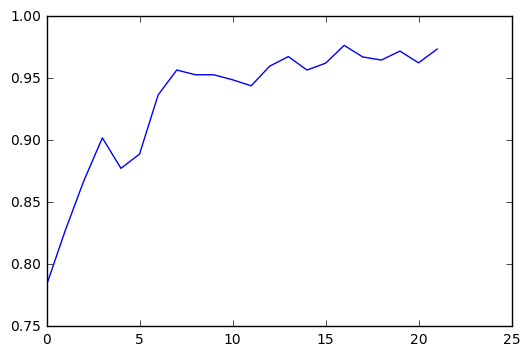

In [24]:
plt.plot(a)
plt.show()

In [68]:
clf = RandomForestClassifier(n_estimators=np.argmax(a))

### overfitting curve

In [69]:
def random_shuffle(X, y, ratio):
    idx = np.random.permutation(training_data_x.index)
    num_train = int(X.shape[0] * ratio)
    return X.ix[idx[:num_train],:], y.ix[idx[:num_train]], X.ix[idx[num_train:], :], y.ix[idx[num_train:]]

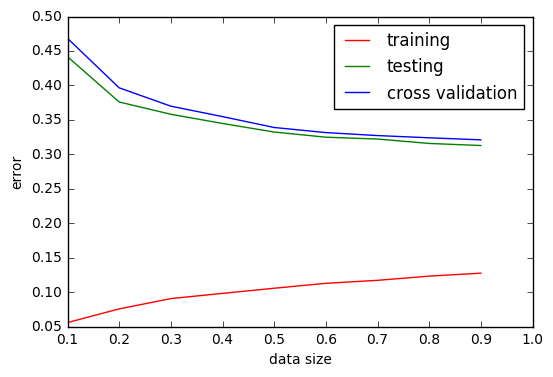

In [124]:
clf = RandomForestClassifier(n_estimators=10, max_features=4)
ratio_grid = np.arange(1,10)/10
tr_mat = []
te_mat = []
cross_score = []
for i in ratio_grid:
    x_tr, y_tr, x_te, y_te = random_shuffle(training_data_x.ix[:,[2,3,6,7,9,10,12,15]], training_data_y, i)
    clf.fit(X=x_tr, y=y_tr)
    cross_score.append(cross_val_score(clf,x_tr, y_tr, cv = 5).mean())
    tr_mat.append(clf.score(x_tr, y_tr))
    te_mat.append(clf.score(x_te, y_te))
    #print(clf.score(x_tr, y_tr))
    #print(clf.score(x_te, y_te))    
plt.figure()
plt.plot(ratio_grid,1-np.array(tr_mat),'r',label='training')
plt.plot(ratio_grid,1-np.array(te_mat),'g',label='testing')
plt.plot(ratio_grid,1-np.array(cross_score),'b', label = 'cross validation')
plt.xlabel('data size')
plt.ylabel('error')
plt.legend()
plt.show()

### feature importance

We partition the training data into two subsets, one called \{x_tr, t_tr\}, the other is called \{x_te, y_te\}. We perform training on \{x_tr, t_tr\}, then we compute the accuracy score on set \{x_te, y_te\}.  Later, we compute the feature importance and select the most important 5 features, and we do cross validation on set \{x_te, y_te\} only using these 5 features. As shown below, the difference between accuracy score on whole set of \{x_te, y_te\} and cross validation score on 5 features of \{x_te, y_te\} is only 0.05. It shows that these 5 feature are indeed play an significant role on the skin estimation.

In [155]:
# define a classifier
clf = RandomForestClassifier()
x_tr, y_tr, x_te, y_te = random_shuffle(training_data_x, training_data_y, 0.5)
clf.fit(X=x_tr, y=y_tr)
features = clf.feature_importances_
important_features = np.arange(len(features))[features > 0.1]
print('The most important fearure index are: ',important_features)
print('The testing data accuracy score is:',clf.score(X=x_te, y=y_te))
# perform cross validation at testing data and compute the score
cross_validation_mean = cross_val_score(clf,x_te.ix[:,important_features], y_te, cv = 20).mean()
print('Cross validation mean value for testing data:', cross_validation_mean)
print('The difference of the score:', cross_validation_mean-clf.score(X=x_te, y=y_te))

The most important fearure index are:  [0 2 3 4 5]
The testing data accuracy score is: 0.94744414627
Cross validation mean value for testing data: 0.99988681508
The difference of the score: 0.0524426688092


## Assignment 2

In [164]:
# load the data
filename = 'CrowdstormingDataJuly1st.csv'
df2 = pd.read_csv(filename)

In [165]:
df2.ix[:4,:13]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0


In [166]:
df2.ix[:4,13:]

,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,1,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


In [171]:
df3 = df2.groupby(['playerShort']).mean()

In [184]:
df3.dropna(inplace = True)

In [185]:
df3

,height,weight,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,rater1,rater2,refNum,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
playerShort,,,,,,,,,,,,,,,,,,,,
aaron-hughes,182.0,71.0,3.939759,1.487952,1.078313,1.373494,0.054217,0.114458,0.000000,0.000000,0.25,0.00,1612.656627,43.921687,0.346459,19710.156627,0.000652,0.494575,20637.277108,0.004065
aaron-hunt,183.0,73.0,3.393939,1.424242,0.737374,1.232323,0.626263,0.424242,0.000000,0.010101,0.00,0.25,1662.515152,25.070707,0.348818,26104.292929,0.000219,0.449220,26864.454545,0.000993
aaron-lennon,165.0,63.0,4.079208,1.980198,0.960396,1.138614,0.306931,0.108911,0.000000,0.000000,0.25,0.25,1598.871287,42.772277,0.345893,21234.861386,0.000367,0.491482,22238.742574,0.002032
aaron-ramsey,178.0,76.0,2.500000,1.442308,0.403846,0.653846,0.375000,0.298077,0.000000,0.009615,0.00,0.00,1668.500000,45.067308,0.346821,38285.826923,0.003334,0.514693,39719.980769,0.013522
abdelhamid-el-kaoutari,180.0,73.0,3.351351,1.108108,1.081081,1.162162,0.027027,0.216216,0.108108,0.054054,0.25,0.25,1610.891892,17.189189,0.331600,2832.351351,0.001488,0.335587,2953.837838,0.005296
abdou-traore_2,180.0,74.0,2.309524,0.976190,0.547619,0.785714,0.071429,0.261905,0.023810,0.000000,0.75,0.75,1650.976190,17.642857,0.320079,4523.666667,0.002797,0.296562,4741.404762,0.007958
abdoulaye-diallo_2,189.0,80.0,1.200000,0.400000,0.400000,0.400000,0.000000,0.000000,0.000000,0.000000,0.75,1.00,1685.850000,16.750000,0.341625,2646.700000,0.000237,0.400818,2762.500000,0.000969
abdoulaye-keita_2,188.0,83.0,1.500000,0.000000,0.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.75,1.00,705.500000,14.000000,0.355406,1728.000000,0.000433,0.417225,1808.500000,0.001777
abdoulwhaid-sissoko,180.0,68.0,2.160714,0.607143,0.446429,1.107143,0.053571,0.375000,0.000000,0.035714,1.00,1.00,1510.214286,6.303571,0.348178,2470.196429,0.000180,0.429630,2593.214286,0.000743


In [176]:
from sklearn.decomposition import PCA

In [219]:
pca = PCA(n_components=2)

In [230]:
A = pca.fit_transform(df3.ix[:,[0,1,2,3,4,5,6,7,8,9,10,11,14,15,16,17,18,19]])

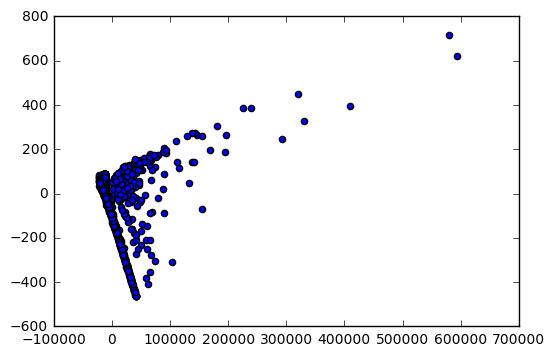

In [231]:
plt.scatter(A[:,0],A[:,1])
plt.show()

In [195]:
import plotly.plotly as py
import plotly.graph_objs as go
py.sign_in('qws', '0r90qkyloj')

In [197]:
trace1 = go.Scatter3d(
    x=A[:,0],
    y=A[:,1],
    z=A[:,2],
    mode='markers',
    marker=dict(
        size=6,
        symbol='star-square',
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~qws/0 or inside your plot.ly account where it is named 'simple-3d-scatter'


In [198]:
from sklearn.cluster import DBSCAN

In [208]:
db = DBSCAN(eps=0.7, min_samples=5).fit(df3)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [209]:
db.core_sample_indices_

array([], dtype=int64)

In [203]:
np.argwhere(labels!=-1)

array([], shape=(0, 1), dtype=int64)